In [1]:
#### now add the mapillary info

In [2]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
from tqdm import tqdm


from shapely.geometry import box


### get mapillary_coverage

In [3]:
mapillary_coverage = gpd.read_parquet("ml_output/mapillary_coverage_germany_buffered10m_dissolved_23-01-01_until_25-10-07.parquet")
mapillary_coverage

,tile_x,tile_y,is_pano,geometry
0,8459,5481,False,"MULTIPOLYGON (((280456.168 5660080.228, 280456..."
1,8460,5481,False,"MULTIPOLYGON (((282105.951 5659027.847, 282105..."
2,8460,5482,False,"MULTIPOLYGON (((281846.71 5657750.623, 281845...."
3,8460,5483,False,"MULTIPOLYGON (((282708.504 5656031.273, 282709..."
4,8460,5484,False,"MULTIPOLYGON (((282208.688 5654394.299, 282207..."
...,...,...,...,...
88539,8875,5463,False,"POLYGON ((918665.61 5700642.981, 918666.488 57..."
88540,8875,5464,False,"MULTIPOLYGON (((920359.562 5697894.491, 920379..."
88541,8875,5465,False,"MULTIPOLYGON (((920442.317 5697275.545, 920442..."
88542,8875,5466,False,"POLYGON ((919460.581 5694604.443, 919459.652 5..."


In [4]:
mapillary_coverage = mapillary_coverage.to_crs(25832)

mapillary_clean = mapillary_coverage.explode(index_parts=False, ignore_index=True)
mapillary_clean

,tile_x,tile_y,is_pano,geometry
0,8459,5481,False,"POLYGON ((280456.168 5660080.228, 280456.566 5..."
1,8459,5481,False,"POLYGON ((281899.417 5659048.905, 281900.331 5..."
2,8459,5481,False,"POLYGON ((281753.108 5659058.591, 281754.102 5..."
3,8459,5481,False,"POLYGON ((281675.69 5659376.219, 281676.341 56..."
4,8460,5481,False,"POLYGON ((282105.951 5659027.847, 282105.45 56..."
...,...,...,...,...
162525,8875,5465,False,"POLYGON ((920442.317 5697275.545, 920442.591 5..."
162526,8875,5465,False,"POLYGON ((920419.395 5697557.442, 920419.455 5..."
162527,8875,5465,False,"POLYGON ((920409.498 5697675.212, 920409.337 5..."
162528,8875,5466,False,"POLYGON ((919460.581 5694604.443, 919459.652 5..."


### get the roads of interest

In [5]:
# ~3min
osm_roads = gpd.read_parquet("processed_osm_files/processed_highways_germany_251006.parquet",
                             columns=["osm_id", "geometry"])

In [6]:
# direkt das pbf laden -> langsam!
# set_date = "251006" 

# gdf = gpd.read_file(f"processed_osm_files/processed_highways_germany_{set_date}.pbf", layer="lines")


In [7]:
osm_roads

,osm_id,geometry
0,92,"LINESTRING (13.73698 51.01663, 13.73752 51.016..."
1,93,"LINESTRING (13.73939 51.01669, 13.73967 51.016..."
2,99,"LINESTRING (11.36639 48.17411, 11.36643 48.174..."
3,100,"LINESTRING (11.33037 48.1801, 11.33032 48.1801..."
4,103,"LINESTRING (13.74127 51.01615, 13.74149 51.016..."
...,...,...
15588341,1435994707,"LINESTRING (13.47324 52.60144, 13.47482 52.602..."
15588342,1435994708,"LINESTRING (13.47305 52.60124, 13.47306 52.601..."
15588343,1435995301,"LINESTRING (10.12586 50.95701, 10.12591 50.957..."
15588344,1435995302,"LINESTRING (10.13217 50.95939, 10.13226 50.959..."


In [8]:
# from shapely.validation import make_valid

# osm_roads["geometry"] = osm_roads.geometry.map(make_valid)

In [9]:
# ~ 30s

osm_roads=osm_roads.to_crs(25832)

## Falls RAM volläuft dann sowas machen:

# import numpy as np

# target = "EPSG:25832"
# src = osm_roads.crs or "EPSG:4326"  # falls oben gesetzt

# idx = np.array_split(np.arange(len(osm_roads)), 20)  # 20 Batches; passe an
# out = []

# for chunk in idx:
#     g = osm_roads.iloc[chunk]
#     out.append(g.to_crs(target))

# osm_roads_25832 = pd.concat(out, ignore_index=True)
# print(osm_roads_25832.crs)


In [10]:
osm_roads['length_m_before_clip'] = osm_roads.geometry.length
osm_roads

,osm_id,geometry,length_m_before_clip
0,92,"LINESTRING (832194.125 5662359.794, 832231.203...",386.707524
1,93,"LINESTRING (832362.761 5662377.712, 832384.518...",89.421440
2,99,"LINESTRING (675921.969 5338360.059, 675924.648...",36.439158
3,100,"LINESTRING (673224.184 5338944.301, 673220.116...",98.561214
4,103,"LINESTRING (832498.092 5662325.944, 832513.585...",97.989768
...,...,...,...
15588341,1435994707,"LINESTRING (802876.929 5837336.439, 802975.241...",252.525048
15588342,1435994708,"LINESTRING (802865.618 5837314.023, 802866.299...",25.593304
15588343,1435995301,"LINESTRING (579073.283 5645647.785, 579076.793...",509.471182
15588344,1435995302,"LINESTRING (579512.441 5645918.632, 579518.468...",203.341994


In [11]:

## germany pano only: Processing roads: 100%|██████████| 15236515/15236515 [1:44:08<00:00, 2438.40it/s]  

## germany all: ~ 10h


## Processing roads:  24%|██▍       | 3748468/15588346 [2:25:24<335:15:05,  9.81it/s]  

## Processing roads:  17%|█▋        | 2706348/15588346 [33:47<2:20:14, 1530.92it/s]


def spatial_filter(gdf, geom):
    idx = gdf.sindex.query(geom, predicate="intersects")
    return gdf.iloc[idx]


network = osm_roads.copy()
mapillary_buffer_layer = mapillary_clean#.copy()

mapillary_buffer_layer_pano=mapillary_buffer_layer[mapillary_buffer_layer.is_pano==True].copy()
mapillary_buffer_layer_regular=mapillary_buffer_layer[mapillary_buffer_layer.is_pano==False].copy()

clipped_lines_pano = []
clipped_lines_regular = []

clipped_gdf_pano = gpd.GeoDataFrame()
clipped_gdf_regular = gpd.GeoDataFrame()

for _, row in tqdm(network.iterrows(), total=len(network), desc="Processing roads"):
    bbox = box(*row.geometry.bounds)


    # do for pano and non-pano
    filtered_polys_pano = spatial_filter(mapillary_buffer_layer_pano, bbox) 
    filtered_polys_regular = spatial_filter(mapillary_buffer_layer_regular, bbox) 

    
    if not filtered_polys_pano.empty:
        clipped_pano = gpd.clip(gpd.GeoDataFrame([row], crs=network.crs), filtered_polys_pano)
        clipped_lines_pano.append(clipped_pano)

    if not filtered_polys_regular.empty:
        clipped_regular = gpd.clip(gpd.GeoDataFrame([row], crs=network.crs), filtered_polys_regular)
        clipped_lines_regular.append(clipped_regular)


# Combine all results
clipped_gdf_pano = gpd.GeoDataFrame(pd.concat(clipped_lines_pano, ignore_index=True), crs=network.crs)
clipped_gdf_regular = gpd.GeoDataFrame(pd.concat(clipped_lines_regular, ignore_index=True), crs=network.crs)


Processing roads: 100%|██████████| 15588346/15588346 [3:01:24<00:00, 1432.13it/s]  


In [12]:
clipped_gdf_pano['length_m_after_clip'] = clipped_gdf_pano.geometry.length
clipped_gdf_pano["mp_coverage_ratio"] = clipped_gdf_pano["length_m_after_clip"] / clipped_gdf_pano["length_m_before_clip"]

clipped_gdf_regular['length_m_after_clip'] = clipped_gdf_regular.geometry.length
clipped_gdf_regular["mp_coverage_ratio"] = clipped_gdf_regular["length_m_after_clip"] / clipped_gdf_regular["length_m_before_clip"]


In [14]:
clipped_gdf_pano=clipped_gdf_pano[["osm_id", "mp_coverage_ratio", "length_m_before_clip", "length_m_after_clip", "geometry"]].copy()
clipped_gdf_pano.to_parquet("germany_osm-highways_25-10-06_mp_pano_coverage_25-10-07_ratio.parquet")

clipped_gdf_regular=clipped_gdf_regular[["osm_id", "mp_coverage_ratio", "length_m_before_clip", "length_m_after_clip", "geometry"]].copy()
clipped_gdf_regular.to_parquet("germany_osm-highways_25-10-06_mp_regular_coverage_25-10-07_ratio.parquet")

In [15]:
# clipped_gdf_pano=clipped_gdf_pano[["osm_id", "highway", "mp_coverage_ratio", "length_m_before_clip", "length_m_after_clip", "geometry"]].copy()
# clipped_gdf_pano.to_parquet("germany_osm-highways_25-10-06_mp_pano_coverage_25-10-07_ratio.parquet")

# clipped_gdf_regular=clipped_gdf_regular[["osm_id", "highway", "mp_coverage_ratio", "length_m_before_clip", "length_m_after_clip", "geometry"]].copy()
# clipped_gdf_regular.to_parquet("germany_osm-highways_25-10-06_mp_regular_coverage_25-10-07_ratio.parquet")

In [16]:
clipped_gdf_pano

,osm_id,mp_coverage_ratio,length_m_before_clip,length_m_after_clip,geometry
0,680,1.000000,111.315259,111.315259,"LINESTRING (688736.164 5344549.747, 688846.103..."
1,1978,1.000000,66.017066,66.017066,"LINESTRING (560704.881 5924993.391, 560746.381..."
2,1880866,0.021153,498.687025,10.548804,"LINESTRING (559385.712 5925758.496, 559385.235..."
3,1880870,0.020579,435.853088,8.969463,"LINESTRING (558952.398 5925821.928, 558951.364..."
4,1881164,0.044864,222.833428,9.997157,"LINESTRING (559031.861 5925802.316, 559032.015..."
...,...,...,...,...,...
764157,1435985709,1.000000,402.610883,402.610883,"LINESTRING (453982.855 5419593.705, 453980.487..."
764158,1435989972,0.155430,6.585792,1.023633,"LINESTRING (818889.529 5820677.255, 818889.789..."
764159,1435989986,0.216426,90.160526,19.513075,"LINESTRING (818884.51 5820658.399, 818886.468 ..."
764160,1435989994,0.060086,160.849663,9.664803,"LINESTRING (818942.501 5820873.788, 818944.088..."


In [17]:
clipped_gdf_regular


,osm_id,mp_coverage_ratio,length_m_before_clip,length_m_after_clip,geometry
0,92,0.016390,386.707524,6.338077,"LINESTRING (832496.697 5662523.041, 832502.818..."
1,93,0.090189,89.421440,8.064868,"LINESTRING (832423.434 5662331.279, 832431.105..."
2,104,1.000000,501.935353,501.935353,"LINESTRING (832455.092 5663161.286, 832453.819..."
3,107,0.336806,40.495102,13.638997,"LINESTRING (832042.49 5662629.528, 832042.063 ..."
4,109,0.084293,139.461499,11.755695,"LINESTRING (832159.28 5662633.803, 832160.531 ..."
...,...,...,...,...,...
2983013,1435994704,1.000000,122.996334,122.996334,"LINESTRING (803191.898 5837764.345, 803260.773..."
2983014,1435994705,1.000000,25.014844,25.014844,"LINESTRING (803157.476 5837713.601, 803171.52 ..."
2983015,1435994706,1.000000,102.384943,102.384943,"LINESTRING (803022.363 5837542.141, 803088.908..."
2983016,1435994707,1.000000,252.525048,252.525048,"LINESTRING (802876.929 5837336.439, 802975.241..."


--------------------

In [18]:
bland = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/1_sehr_hoch.geo.json")
bland=bland[bland["id"].isin(["DE-BE"])]

In [19]:
bland=bland.to_crs(25832)

In [22]:
clipped_gdf_pano_clipped = gpd.clip(clipped_gdf_pano, bland)
clipped_gdf_pano_clipped

,osm_id,mp_coverage_ratio,length_m_before_clip,length_m_after_clip,geometry
214876,136699503,1.000000,526.608371,526.608371,"LINESTRING (797566.153 5814481.162, 797821.559..."
73969,27950346,0.067996,189.267085,12.869434,"LINESTRING (797709.623 5815581.574, 797707.916..."
73970,27950348,0.111637,113.661876,12.688862,"LINESTRING (797709.489 5815595.586, 797712.728..."
74201,27998686,0.258256,99.110763,25.595981,"LINESTRING (797740.316 5815611.824, 797745.085..."
83596,29434387,0.957761,256.279301,245.454357,"MULTILINESTRING ((797628.267 5815563.931, 7976..."
...,...,...,...,...,...
271923,203832319,0.000586,186.565781,0.109280,"LINESTRING (802632.636 5842197.72, 802632.547 ..."
568426,1076483300,0.242835,21.911763,5.320952,"LINESTRING (802509.212 5843454.173, 802508.196..."
32561,23312399,0.891379,9.543314,8.506710,"LINESTRING (802530.292 5843459.419, 802521.793..."
37092,23986734,0.030752,184.359194,5.669365,"LINESTRING (802281.767 5843477.708, 802280.576..."


<Axes: >

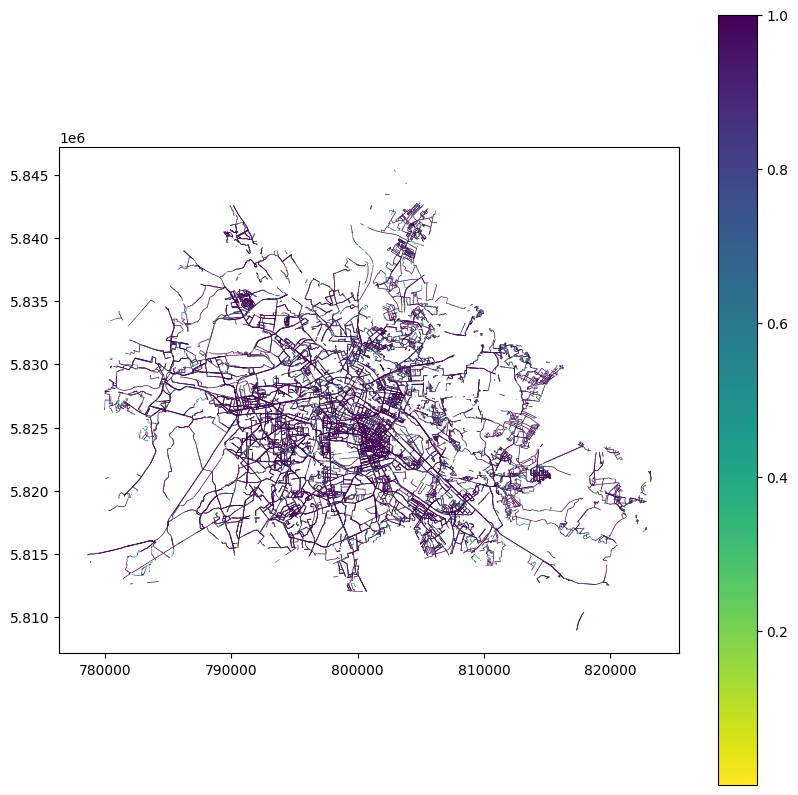

In [27]:
clipped_gdf_pano_clipped.plot(column="mp_coverage_ratio", cmap="viridis_r", linewidth=0.5, legend=True, figsize=(10, 10))

In [25]:
clipped_gdf_regular_clipped = gpd.clip(clipped_gdf_regular, bland)
clipped_gdf_regular_clipped

,osm_id,mp_coverage_ratio,length_m_before_clip,length_m_after_clip,geometry
2759730,1279963612,0.211848,73.133553,15.493222,"LINESTRING (800571.531 5812226.407, 800574.152..."
2635667,1190680737,1.000000,4.195181,4.195181,"LINESTRING (800575.049 5812236.502, 800578.783..."
2635664,1190680734,1.000000,6.591163,6.591163,"LINESTRING (800578.783 5812238.415, 800581.921..."
2635665,1190680735,1.000000,3.197898,3.197898,"LINESTRING (800584.656 5812241.407, 800587.502..."
2062136,702310774,1.000000,6.608102,6.608102,"LINESTRING (800587.502 5812242.864, 800590.475..."
...,...,...,...,...,...
117925,22928947,0.059119,206.973375,12.236025,"LINESTRING (802919.947 5844790.66, 802915.429 ..."
884919,114876396,0.637428,703.880199,448.673193,"MULTILINESTRING ((802876.274 5845443.799, 8028..."
1196260,197689751,1.000000,689.080983,689.080983,"LINESTRING (802986.377 5845291.072, 802982.836..."
2254145,881562217,1.000000,8.940321,8.940321,"LINESTRING (802982.836 5845296.542, 802986.125..."


<Axes: >

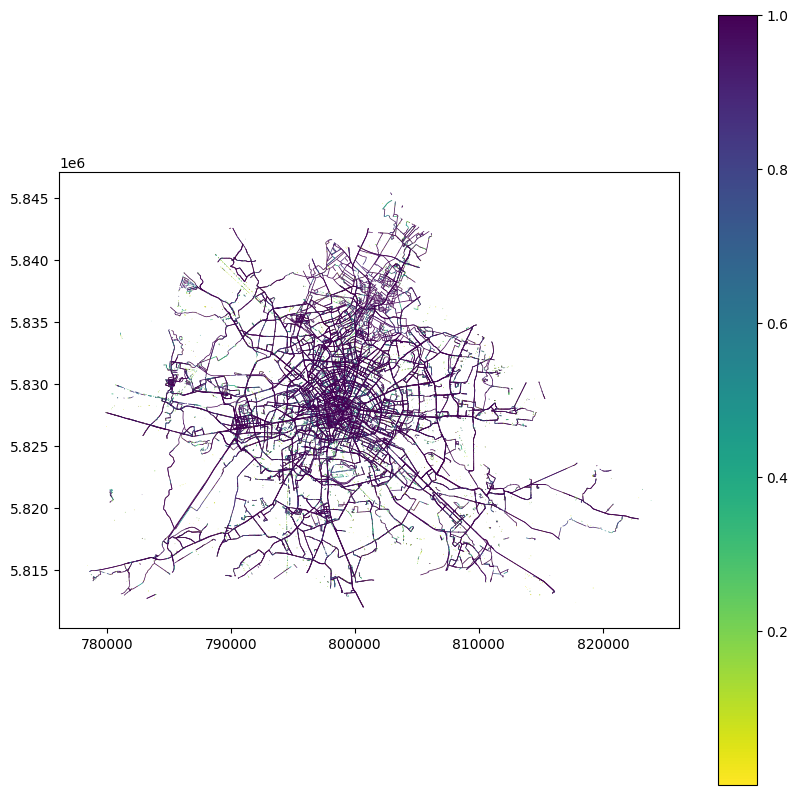

In [28]:
clipped_gdf_regular_clipped.plot(column="mp_coverage_ratio", cmap="viridis_r", linewidth=0.5, legend=True, figsize=(10, 10))

-------------------

### EXPERIMENTAL.....

In [16]:
network = osm_roads_clipped.copy()
mapillary_buffer_layer = mapillary_clean_clipped.copy()

In [ ]:
## to speed up the diff length calculation: the ida was to create a generic grid that would cut the mapillary buffer layer to make the polygones less complex...
## however the gain seems to be marginal....

In [17]:
from shapely.geometry import box
import geopandas as gpd
import numpy as np

def create_grid(bounds, cell_size):
    xmin, ymin, xmax, ymax = bounds
    rows = int(np.ceil((ymax - ymin) / cell_size))
    cols = int(np.ceil((xmax - xmin) / cell_size))
    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            x1 = xmin + i * cell_size
            y1 = ymin + j * cell_size
            x2 = x1 + cell_size
            y2 = y1 + cell_size
            grid_cells.append(box(x1, y1, x2, y2))
    return gpd.GeoDataFrame(geometry=grid_cells, crs="25832")

# Example: 500m grid
grid = create_grid(mapillary_buffer_layer.total_bounds, cell_size=500)


In [18]:
# Spatial join polygons to grid
joined = gpd.sjoin(mapillary_buffer_layer, grid, predicate="intersects", how="inner")

# Intersect polygons with their grid cell
split_polys = gpd.overlay(joined, grid, how="intersection")

In [19]:
split_polys

,tile_x,tile_y,is_pano,index_right,geometry
0,8813.0,5385.0,True,5774,"POLYGON ((817730.951 5810111.307, 817736.105 5..."
1,8814.0,5385.0,True,5774,"POLYGON ((817885.556 5810316.989, 817885.431 5..."
2,8814.0,5384.0,False,5778,"POLYGON ((817798.343 5812405.772, 817798.329 5..."
3,8815.0,5384.0,True,6001,"POLYGON ((819436.37 5812747.293, 819436.342 58..."
4,8815.0,5384.0,True,6001,"POLYGON ((819893.835 5812501.571, 819895.929 5..."
...,...,...,...,...,...
74809,8805.0,5361.0,True,3625,"POLYGON ((802893.333 5845442.983, 802887.589 5..."
74810,8805.0,5361.0,True,3625,"POLYGON ((802947.69 5845380.911, 802951.218 58..."
74811,8805.0,5361.0,True,3698,"POLYGON ((802938.712 5845355.881, 802938.414 5..."
74812,8805.0,5361.0,True,3698,"POLYGON ((802893.333 5845442.983, 802887.589 5..."


In [21]:
network

,osm_id,name,highway,waterway,aerialway,barrier,man_made,railway,z_order,other_tags,geometry,length_m_before_clip
1933661,34282843,None,path,None,None,None,None,None,0,"""foot""=>""yes"",""lit""=>""no"",""surface""=>""ground""","LINESTRING (781867.342 5812263.282, 781821.178...",314.109498
1772538,32858548,None,track,None,None,None,None,None,0,"""motor_vehicle""=>""forestry"",""tracktype""=>""grade4""","LINESTRING (783844.789 5812762.442, 783848.409...",1395.003464
1772641,32858962,None,path,None,None,None,None,None,0,None,"LINESTRING (783663.679 5812648.614, 783656.256...",443.274417
5821578,184060395,None,track,None,None,None,None,None,0,"""lit""=>""no"",""motor_vehicle""=>""forestry"",""smoot...","LINESTRING (781794.614 5812185.745, 781793.522...",1563.177319
388397,23291292,Kohlhasenbrücker Straße,track,None,None,None,None,None,0,"""lit""=>""no"",""motor_vehicle""=>""forestry"",""name:...","MULTILINESTRING ((782041.143 5813070.098, 7820...",1008.366195
...,...,...,...,...,...,...,...,...,...,...,...,...
3031947,54428616,None,path,None,None,None,None,None,0,"""access""=>""private""","LINESTRING (786668.228 5838978.736, 786627.078...",123.710496
10896724,733572654,None,path,None,None,None,None,None,0,"""access""=>""destination"",""surface""=>""dirt""","LINESTRING (786587.563 5838971.653, 786572.414...",58.116703
8696307,394937701,S Heiligensee,platform,None,None,None,None,None,0,"""bench""=>""yes"",""bin""=>""yes"",""bus""=>""yes"",""chec...","LINESTRING (786242.109 5838982.401, 786256.528...",18.860326
8264773,356524693,None,footway,None,None,None,None,None,0,"""surface""=>""ground""","LINESTRING (786498.006 5838982.981, 786501.776...",34.986366


In [24]:
import geopandas as gpd


split_polys = split_polys.drop(columns=["index_right"], errors="ignore")

# Perform spatial join to get only intersecting roads
relevant_lines = gpd.sjoin(network, split_polys, how="inner", predicate="intersects")

# Drop duplicates in case roads intersect multiple polygons
relevant_lines = network.loc[relevant_lines.index].drop_duplicates().copy()

In [25]:
relevant_lines

,osm_id,name,highway,waterway,aerialway,barrier,man_made,railway,z_order,other_tags,geometry,length_m_before_clip
1772538,32858548,None,track,None,None,None,None,None,0,"""motor_vehicle""=>""forestry"",""tracktype""=>""grade4""","LINESTRING (783844.789 5812762.442, 783848.409...",1395.003464
1772641,32858962,None,path,None,None,None,None,None,0,None,"LINESTRING (783663.679 5812648.614, 783656.256...",443.274417
388397,23291292,Kohlhasenbrücker Straße,track,None,None,None,None,None,0,"""lit""=>""no"",""motor_vehicle""=>""forestry"",""name:...","MULTILINESTRING ((782041.143 5813070.098, 7820...",1008.366195
2492249,40774184,None,track,None,None,None,None,None,0,"""lit""=>""no"",""surface""=>""dirt"",""tracktype""=>""gr...","LINESTRING (782194.153 5812630.979, 782195.364...",117.524062
66614,4779627,None,track,None,None,None,None,None,0,"""lit""=>""no"",""motor_vehicle""=>""forestry"",""smoot...","LINESTRING (781987.288 5812619.651, 782075.854...",1620.890164
...,...,...,...,...,...,...,...,...,...,...,...,...
9220731,460995019,None,footway,None,None,None,None,None,0,"""surface""=>""paving_stones""","LINESTRING (786257.892 5838938.836, 786268.951...",16.134257
9220732,460995020,None,footway,None,None,None,None,None,0,"""surface""=>""paving_stones""","LINESTRING (786254.43 5838963.093, 786245.05 5...",39.797486
8722927,397624119,Ruppiner Chaussee,secondary,None,None,None,None,None,6,"""cycleway""=>""track"",""cycleway:left:surface""=>""...","LINESTRING (786328.223 5838897.652, 786317.64 ...",162.048941
8696307,394937701,S Heiligensee,platform,None,None,None,None,None,0,"""bench""=>""yes"",""bin""=>""yes"",""bus""=>""yes"",""chec...","LINESTRING (786242.109 5838982.401, 786256.528...",18.860326


In [33]:
network = osm_roads.copy()
mapillary_buffer_layer = mapillary_clean.copy()

In [34]:
len(network)


15296454

In [35]:
#mapillary_clean_clipped.plot()

In [38]:
### pano only:

## germany pano only: Processing roads: 100%|██████████| 15236515/15236515 [1:44:08<00:00, 2438.40it/s]  

## germany all: ~ 10h


from shapely.geometry import box
from tqdm import tqdm

def spatial_filter(gdf, geom):
    idx = gdf.sindex.query(geom, predicate="intersects")
    return gdf.iloc[idx]


#sample=osm_roads_2024_intersect_landuse[:1500].copy()
#sample=osm_roads_2024_intersect_landuse.copy()


network = osm_roads.copy()
mapillary_buffer_layer = mapillary_clean.copy()

mapillary_buffer_layer_pano=mapillary_buffer_layer[mapillary_buffer_layer.is_pano==True].copy()
mapillary_buffer_layer_regular=mapillary_buffer_layer[mapillary_buffer_layer.is_pano==False].copy()

clipped_lines_pano = []
clipped_lines_regular = []

clipped_gdf_pano = gpd.GeoDataFrame()
clipped_gdf_regular = gpd.GeoDataFrame()

for _, row in tqdm(network.iterrows(), total=len(network), desc="Processing roads"):
    bbox = box(*row.geometry.bounds)


    # do for pano and non-pano
    filtered_polys_pano = spatial_filter(mapillary_buffer_layer_pano, bbox) 
    filtered_polys_regular = spatial_filter(mapillary_buffer_layer_regular, bbox) 

    
    if not filtered_polys_pano.empty:
        clipped_pano = gpd.clip(gpd.GeoDataFrame([row], crs=network.crs), filtered_polys_pano)
        clipped_lines_pano.append(clipped_pano)

    if not filtered_polys_regular.empty:
        clipped_regular = gpd.clip(gpd.GeoDataFrame([row], crs=network.crs), filtered_polys_regular)
        clipped_lines_regular.append(clipped_regular)


# Combine all results
clipped_gdf_pano = gpd.GeoDataFrame(pd.concat(clipped_lines_pano, ignore_index=True), crs=network.crs)
clipped_gdf_regular = gpd.GeoDataFrame(pd.concat(clipped_lines_regular, ignore_index=True), crs=network.crs)


Processing roads: 100%|██████████| 15296454/15296454 [11:06:53<00:00, 382.29it/s]   


In [39]:
clipped_gdf_pano['length_m_after_clip'] = clipped_gdf_pano.geometry.length
clipped_gdf_pano["mp_coverage_ratio"] = clipped_gdf_pano["length_m_after_clip"] / clipped_gdf_pano["length_m_before_clip"]

clipped_gdf_regular['length_m_after_clip'] = clipped_gdf_regular.geometry.length
clipped_gdf_regular["mp_coverage_ratio"] = clipped_gdf_regular["length_m_after_clip"] / clipped_gdf_regular["length_m_before_clip"]


In [40]:
clipped_gdf_pano=clipped_gdf_pano[["osm_id", "highway", "mp_coverage_ratio", "length_m_before_clip", "length_m_after_clip", "geometry"]].copy()
clipped_gdf_pano.to_parquet("germany_osm-highways_25-05-09_mp_pano_coverage_25-05-10_ratio.parquet")

clipped_gdf_regular=clipped_gdf_regular[["osm_id", "highway", "mp_coverage_ratio", "length_m_before_clip", "length_m_after_clip", "geometry"]].copy()
clipped_gdf_regular.to_parquet("germany_osm-highways_25-05-09_mp_regular_coverage_25-05-10_ratio.parquet")

In [37]:
clipped_gdf_pano

,osm_id,highway,mp_coverage_ratio,length_m_before_clip,length_m_after_clip,geometry
0,1978,primary,1.000000,66.017066,66.017066,"LINESTRING (560704.881 5924993.391, 560746.381..."
1,1880866,residential,0.019283,498.687025,9.615933,"LINESTRING (559385.712 5925758.496, 559385.235..."
2,1880870,residential,0.020499,435.853088,8.934343,"LINESTRING (558952.398 5925821.928, 558951.364..."
3,1881164,residential,0.040049,222.833428,8.924277,"LINESTRING (559031.926 5925803.387, 559032.015..."
4,2293021,path,1.000000,109.656800,109.656800,"LINESTRING (644651.826 5494810.586, 644600.607..."
...,...,...,...,...,...,...
729,4071975,primary,1.000000,408.093128,408.093128,"LINESTRING (793984.906 5832007.377, 794146.24 ..."
730,4071976,residential,1.000000,100.902933,100.902933,"LINESTRING (795441.388 5833847.765, 795426.577..."
731,4071978,primary,0.999567,201.440019,201.352806,"LINESTRING (793218.814 5832397.605, 793226.726..."
732,4071979,secondary,0.354003,15.078935,5.337993,"LINESTRING (793588.972 5835202.236, 793589.942..."


In [ ]:
## germany pano only: Processing roads: 100%|██████████| 15236515/15236515 [1:44:08<00:00, 2438.40it/s]  

## germany all: ~ 10h


from shapely.geometry import box
from tqdm import tqdm

def spatial_filter(gdf, geom):
    idx = gdf.sindex.query(geom, predicate="intersects")
    return gdf.iloc[idx]


#sample=osm_roads_2024_intersect_landuse[:1500].copy()
#sample=osm_roads_2024_intersect_landuse.copy()


network = relevant_lines.copy()
mapillary_buffer_layer = mapillary_clean_clipped.copy()

mapillary_buffer_layer_pano=mapillary_buffer_layer[mapillary_buffer_layer.is_pano==True].copy()
mapillary_buffer_layer_regular=mapillary_buffer_layer[mapillary_buffer_layer.is_pano==False].copy()

clipped_lines_pano = []
clipped_lines_regular = []

clipped_gdf_pano = gpd.GeoDataFrame()
clipped_gdf_regular = gpd.GeoDataFrame()

for _, row in tqdm(network.iterrows(), total=len(network), desc="Processing roads"):
    bbox = box(*row.geometry.bounds)


    # do for pano and non-pano
    filtered_polys_pano = spatial_filter(mapillary_buffer_layer_pano, bbox) 
    filtered_polys_regular = spatial_filter(mapillary_buffer_layer_regular, bbox) 

    
    if not filtered_polys_pano.empty:
        clipped_pano = gpd.clip(gpd.GeoDataFrame([row], crs=network.crs), filtered_polys_pano)
        clipped_lines_pano.append(clipped_pano)

    if not filtered_polys_regular.empty:
        clipped_regular = gpd.clip(gpd.GeoDataFrame([row], crs=network.crs), filtered_polys_regular)
        clipped_lines_regular.append(clipped_regular)

# Combine all results
clipped_gdf_pano = gpd.GeoDataFrame(pd.concat(clipped_lines_pano, ignore_index=True), crs=network.crs)
clipped_gdf_regular = gpd.GeoDataFrame(pd.concat(clipped_lines_regular, ignore_index=True), crs=network.crs)

Processing roads:   0%|          | 0/216024 [00:00<?, ?it/s]

Processing roads:  32%|███▏      | 69391/216024 [04:06<08:41, 281.16it/s] 


KeyboardInterrupt: 

In [ ]:
# ### alternative: use overlay

# import geopandas as gpd

# # Ensure spatial indexes are built
# _ = mapillary_clean_clipped.sindex

# # Split pano and regular once
# mapillary_pano = mapillary_clean_clipped[mapillary_clean_clipped.is_pano].copy()
# mapillary_regular = mapillary_clean_clipped[~mapillary_clean_clipped.is_pano].copy()

# # Overlay (fast, vectorized intersection)
# clipped_gdf_pano = gpd.overlay(osm_roads_clipped, mapillary_pano, how='intersection')
# clipped_gdf_regular = gpd.overlay(osm_roads_clipped, mapillary_regular, how='intersection')

In [27]:
from shapely.geometry import box
from tqdm import tqdm
import geopandas as gpd


network = relevant_lines.copy()
mapillary_buffer_layer = mapillary_clean_clipped[::1000].copy()

# Ensure spatial index is built
_ = mapillary_buffer_layer.sindex

# Pre-filter pano/non-pano
pano_layer = mapillary_buffer_layer[mapillary_buffer_layer.is_pano].copy()
regular_layer = mapillary_buffer_layer[~mapillary_buffer_layer.is_pano].copy()

_ = pano_layer.sindex
_ = regular_layer.sindex

# Pre-allocate lists
clipped_pano = []
clipped_regular = []

# Reuse the same function and GeoDataFrame constructor
def clip_if_intersects(line_geom, polys, crs):
    bbox = box(*line_geom.bounds)
    filtered = polys.iloc[polys.sindex.query(bbox, predicate="intersects")]
    if not filtered.empty:
        return gpd.clip(gpd.GeoDataFrame(geometry=[line_geom], crs=crs), filtered)
    return None

# Iterate over rows
for row in tqdm(network.itertuples(), total=len(network), desc="Clipping roads"):
    line_geom = row.geometry
    pano_clip = clip_if_intersects(line_geom, pano_layer, network.crs)
    if pano_clip is not None:
        clipped_pano.append(pano_clip)

    regular_clip = clip_if_intersects(line_geom, regular_layer, network.crs)
    if regular_clip is not None:
        clipped_regular.append(regular_clip)

# Combine
clipped_gdf_pano = gpd.GeoDataFrame(pd.concat(clipped_pano, ignore_index=True), crs=network.crs)
clipped_gdf_regular = gpd.GeoDataFrame(pd.concat(clipped_regular, ignore_index=True), crs=network.crs)


Clipping roads:  31%|███▏      | 67927/216024 [00:24<00:53, 2759.24it/s]


KeyboardInterrupt: 

In [21]:
clipped_gdf_pano

,geometry,length_m_after_clip
0,"LINESTRING (783844.789 5812762.442, 783845.25 ...",9.158154
1,"LINESTRING (783657.071 5812740.743, 783656.256...",11.395185
2,"LINESTRING (782074.642 5812636.028, 782075.854...",20.276455
3,"LINESTRING (782194.153 5812630.979, 782194.843...",10.278972
4,"LINESTRING (781987.288 5812619.651, 782075.854...",227.155632
...,...,...
149083,"LINESTRING (786257.892 5838938.836, 786268.951...",16.134257
149084,"LINESTRING (786254.43 5838963.093, 786245.05 5...",36.269099
149085,"LINESTRING (786328.223 5838897.652, 786317.64 ...",148.868903
149086,"LINESTRING (786242.109 5838982.401, 786256.528...",18.860326


In [20]:
clipped_gdf_pano

,geometry,length_m_after_clip
0,"LINESTRING (783844.789 5812762.442, 783845.25 ...",9.158154
1,"LINESTRING (783657.071 5812740.743, 783656.256...",11.395185
2,"LINESTRING (782074.642 5812636.028, 782075.854...",20.276455
3,"LINESTRING (782194.153 5812630.979, 782194.843...",10.278972
4,"LINESTRING (781987.288 5812619.651, 782075.854...",227.155632
...,...,...
149083,"LINESTRING (786257.892 5838938.836, 786268.951...",16.134257
149084,"LINESTRING (786254.43 5838963.093, 786245.05 5...",36.269099
149085,"LINESTRING (786328.223 5838897.652, 786317.64 ...",148.868903
149086,"LINESTRING (786242.109 5838982.401, 786256.528...",18.860326


In [19]:
clipped_gdf_pano['length_m_after_clip'] = clipped_gdf_pano.geometry.length
clipped_gdf_pano["mp_coverage_ratio"] = clipped_gdf_pano["length_m_after_clip"] / clipped_gdf_pano["length_m_before_clip"]

clipped_gdf_regular['length_m_after_clip'] = clipped_gdf_regular.geometry.length
clipped_gdf_regular["mp_coverage_ratio"] = clipped_gdf_regular["length_m_after_clip"] / clipped_gdf_regular["length_m_before_clip"]



KeyError: 'length_m_before_clip'

<Axes: >

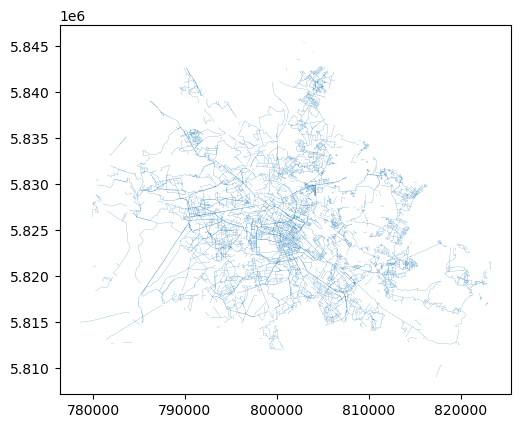

In [18]:
mapillary_buffer_layer = mapillary_clean_clipped.copy()

mapillary_buffer_layer[mapillary_buffer_layer.is_pano==True].plot()

<Axes: >

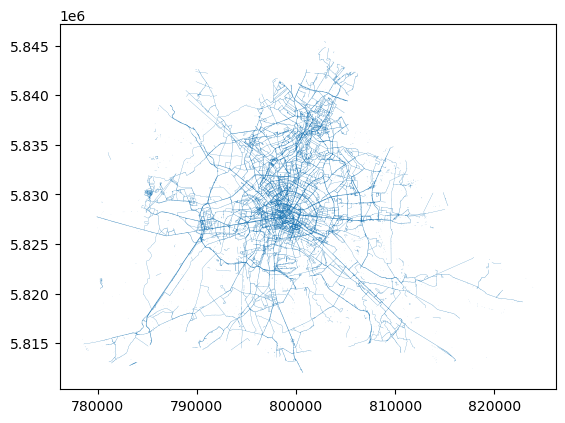

In [19]:
mapillary_buffer_layer = mapillary_clean_clipped.copy()

mapillary_buffer_layer[mapillary_buffer_layer.is_pano==False].plot()

In [ ]:
## germany pano only: Processing roads: 100%|██████████| 15236515/15236515 [1:44:08<00:00, 2438.40it/s]  

## germany all: ~ 10h


from shapely.geometry import box
from tqdm import tqdm

def spatial_filter(gdf, geom):
    idx = gdf.sindex.query(geom, predicate="intersects")
    return gdf.iloc[idx]


#sample=osm_roads_2024_intersect_landuse[:1500].copy()
#sample=osm_roads_2024_intersect_landuse.copy()


clipped_lines = []

clipped_gdf = gpd.GeoDataFrame()

for _, row in tqdm(osm_roads.iterrows(), total=len(osm_roads), desc="Processing roads"):
    bbox = box(*row.geometry.bounds)
    #filtered_polys = mapillary_clean[mapillary_clean.intersects(bbox)]
    filtered_polys = spatial_filter(mapillary_clean, bbox) # 3times faster than intersects
    
    if not filtered_polys.empty:
        clipped = gpd.clip(gpd.GeoDataFrame([row], crs=osm_roads.crs), filtered_polys)
        clipped_lines.append(clipped)

# Combine all results
clipped_gdf = gpd.GeoDataFrame(pd.concat(clipped_lines, ignore_index=True), crs=osm_roads.crs)


Processing roads:  40%|████      | 6105095/15236515 [35:31<30:07, 5052.92it/s]  

In [33]:
clipped_gdf['length_m_after_clip'] = clipped_gdf.geometry.length

clipped_gdf["mp_coverage_ratio"] = clipped_gdf["length_m_after_clip"] / clipped_gdf["length_m_before_clip"]



<Axes: >

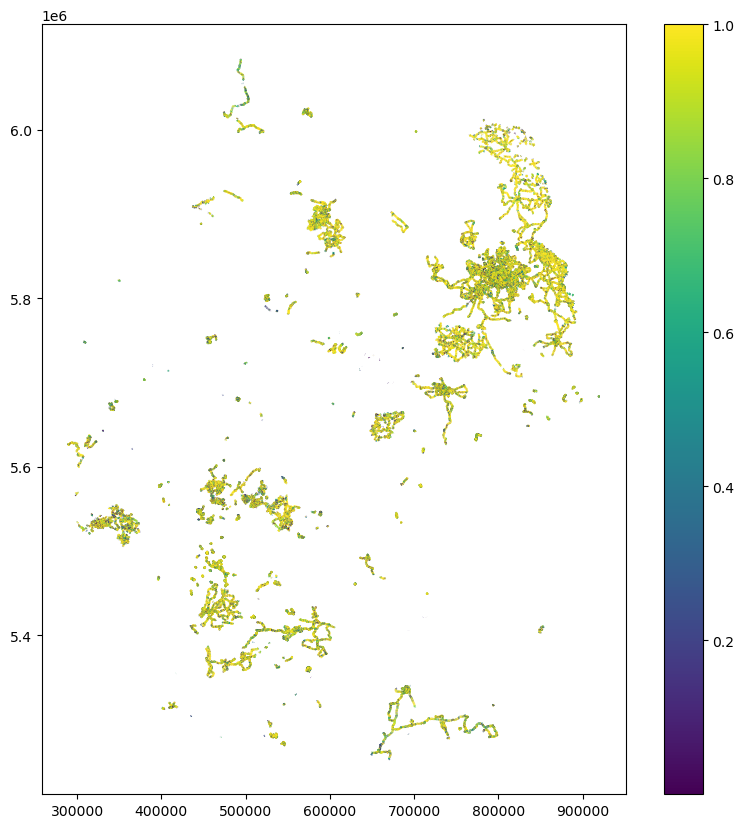

In [16]:
clipped_gdf.plot(column="mp_coverage_ratio", cmap="viridis", legend=True, figsize=(10, 10))

array([[<Axes: title={'center': 'mp_coverage_ratio'}>]], dtype=object)

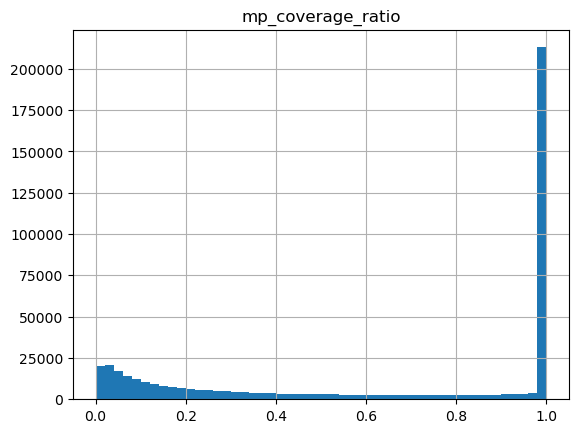

In [17]:
clipped_gdf.hist(column="mp_coverage_ratio", bins=50)

In [18]:
clipped_gdf.columns

Index(['osm_id', 'name', 'highway', 'waterway', 'aerialway', 'barrier',
       'man_made', 'railway', 'z_order', 'other_tags', 'geometry',
       'length_m_before_clip', 'length_m_after_clip', 'mp_coverage_ratio'],
      dtype='object')

In [ ]:
clipped_gdf

In [34]:
#clipped_gdf=clipped_gdf[["id","count_accidents","mp_coverage_ratio", "length_km_before_clip", "length_km_after_clip", "geometry"]].copy()
clipped_gdf=clipped_gdf[["osm_id", "highway", "mp_coverage_ratio", "length_m_before_clip", "length_m_after_clip", "geometry"]].copy()

In [ ]:
#clipped_gdf.to_file("berlin_highways_250401_mp_coverage_ratio.gpkg")
#clipped_gdf.to_file("germany_osm-highways_25-04-05_mp_coverage_25-04-03_ratio.gpkg")


clipped_gdf.to_parquet("germany_osm-highways_25-04-05_mp_pano_coverage_25-04-03_ratio.parquet")
#clipped_gdf.to_parquet("germany_osm-highways_25-04-05_mp_all_coverage_25-04-03_ratio.parquet")